# 第五次作业「使用DQN玩儿星球大战游戏」

游戏部分借鉴了 「yueyangming」 https://github.com/yueyangming/PyTorch_homework/tree/master/homework05-1129 的代码

## 准备游戏

游戏部分代码在 [yueyangming](https://github.com/yueyangming/PyTorch_homework/tree/master/homework05-1129) 代码的基础上做了修改：

* 增加了速度参数，统一了屏幕宽高参数
* 修改了每一帧返回的数据结构

In [2]:
# import the pygame module
import pygame

# import random for random numbers!
import random

# import pygame.locals for easier access to key coordinates
from pygame.locals import *

class Player(pygame.sprite.Sprite):
    def __init__(self, width, height, speed=2):
        super(Player, self).__init__()
        self.image = pygame.image.load('assets/jet.png').convert()
        self.image.set_colorkey((255, 255, 255), RLEACCEL)
        self.rect = self.image.get_rect()
        self.speed = speed
        self.width = width
        self.height = height

    def update(self, pressed_keys):
        if pressed_keys[0]:  # Up
            self.rect.move_ip(0, -self.speed)
        if pressed_keys[1]:  # Down
            self.rect.move_ip(0, self.speed)
        if pressed_keys[2]:  # Left
            self.rect.move_ip(-self.speed, 0)
        if pressed_keys[3]:  # Right
            self.rect.move_ip(self.speed, 0)

        # Keep player on the screen
        if self.rect.left < 0:
            self.rect.left = 0
        elif self.rect.right > self.width:
            self.rect.right = self.width
        if self.rect.top <= 0:
            self.rect.top = 0
        elif self.rect.bottom >= self.height:
            self.rect.bottom = self.height

class Enemy(pygame.sprite.Sprite):
    def __init__(self, width, height, speed_min, speed_max):
        super(Enemy, self).__init__()
        self.image = pygame.image.load('assets/missile.png').convert()
        self.image.set_colorkey((255, 255, 255), RLEACCEL)
        self.rect = self.image.get_rect(
            center=(random.randint(width+20, width+100), random.randint(0, height)))
        self.speed = random.randint(round(speed_min * 100), round(speed_max * 100)) / 100

    def update(self):
        self.rect.move_ip(-self.speed, 0)
        if self.rect.right < 0:
            self.kill()


class Cloud(pygame.sprite.Sprite):
    def __init__(self, width, height, speed=2):
        super(Cloud, self).__init__()
        self.image = pygame.image.load('assets/cloud.png').convert()
        self.image.set_colorkey((0, 0, 0), RLEACCEL)
        self.rect = self.image.get_rect(center=(
            random.randint(width+20, width+100), random.randint(0, height))
        )
        self.speed = speed

    def update(self):
        self.rect.move_ip(-self.speed, 0)
        if self.rect.right < 0:
            self.kill()

class Game(object):
    def __init__(self, width = 800, height = 600, player_speed=2, cloud_speed=2, enemy_min_speed=1.0, enemy_max_speed=3.0):
        # initialize pygame
        pygame.init()
        self.width = width
        self.height = height
        self.cloud_speed = cloud_speed
        self.enemy_min_speed = enemy_min_speed
        self.enemy_max_speed = enemy_max_speed
        self.player_speed = player_speed
        # 30 FPS
#         pygame.time.Clock().tick(30)

        # create the screen object
        # here we pass it a size of 800x600
        self.screen = pygame.display.set_mode((width, height))

        # create our 'player', right now he's just a rectangle
        self.player = Player(width, height, player_speed)

        self.background = pygame.Surface(self.screen.get_size())
        self.background.fill((135, 206, 250))

        self.enemies = pygame.sprite.Group()
        self.clouds = pygame.sprite.Group()
        self.all_sprites = pygame.sprite.Group()
        self.all_sprites.add(self.player)
        self.running = True
        self.framecount = 0

    def get_frame(self, Key_press, QuitFlag = False):
        # 30 FPS
#         pygame.time.Clock().tick(30)
        
        if self.running:
            self.framecount += 1

            if random.random() < 0.13:
                new_enemy = Enemy(self.width, self.height, self.enemy_min_speed, self.enemy_max_speed)
                self.enemies.add(new_enemy)
                self.all_sprites.add(new_enemy)
            
            self.screen.blit(self.background, (0, 0))
            if QuitFlag == True:
                self.running = False
            self.player.update(Key_press)
            self.enemies.update()
            self.clouds.update()
            for entity in self.all_sprites:
                self.screen.blit(entity.image, entity.rect)
                
            reward = 0.01
            terminal = False

            # 撞到子弹
            if pygame.sprite.spritecollideany(self.player, self.enemies):
                reward = -1
                terminal = True
                # self.player.kill()
                # 重新开始
                for entity in self.all_sprites:
                    entity.kill()
                self.__init__(self.width, self.height, self.player_speed, self.cloud_speed, self.enemy_min_speed, self.enemy_max_speed)
            
            image_data = pygame.surfarray.array3d(self.screen)
            
            return image_data, reward, terminal


## 测试游戏

初始化游戏

In [3]:
SCREEN_WIDTH = 240
SCREEN_HEIGHT = 240

# __init__(self, width = 800, height = 600, player_speed=2, cloud_speed=2, enemy_min_speed=1.0, enemy_max_speed=3.0):
game = Game(width = SCREEN_WIDTH, height = SCREEN_HEIGHT, player_speed=8, cloud_speed=5, 
            enemy_min_speed=5.0, enemy_max_speed=10.0)

测试运行游戏

In [4]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import numpy as np

IMAGE_WIDTH = 80
IMAGE_HEIGHT = 80

def show_play(play, step=-1):
    
    fig = plt.figure()
    axe = fig.add_subplot(111)
    dat = np.zeros((IMAGE_HEIGHT, IMAGE_WIDTH))
    img = axe.imshow(dat)
    
    action = [False, False, False, False]
    stop = False

    i = 0
    while True:       
        if step > 0 and i == step:
            break
        if stop:
            break
            
        clear_output(wait = True)
            
        image, reward, game_over = game.get_frame(action, QuitFlag = False)
        # action = [False, True, False, False]  # [UP, Down, Left, Right]
        action, stop = play(i, action, image, reward, game_over)

        image = np.transpose(image, (1, 0, 2))
        img.set_data(image)
        img.autoscale()
        display(fig)
        i+=1


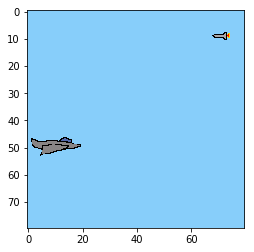

In [4]:
# 定义一个简单的执行函数
def stupid_player(*args):
    return [False, True, False, False], False

# 运行游戏
show_play(stupid_player, 100)

## 准备神经网络

In [5]:
from __future__ import print_function

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import cv2 #需要安装OpenCV的包

import random
import numpy as np
from collections import deque

创建一个多层CNN网络，接收多帧画面，输出为每个可能动作对应的Q函数值

In [6]:
class Net(nn.Module):
    def __init__(self, in_dim, n_class):
        super(Net, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_dim, 32, 9, stride=4, padding=4),   # 80x80 -> 20x20
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),                              # 20x20 -> 10x10
            nn.Conv2d(32, 64, 5, stride=2, padding=2),       # 10x10 -> 5x5
            nn.ReLU(True),
            nn.MaxPool2d(2, 2, padding = 1),                 # 5x5 -> 3x3
            nn.Conv2d(64, 64, 3, stride=1, padding = 1)
        )

        self.fc = nn.Sequential(
            # 64x5x5
            nn.Linear(576, 256),
            nn.Linear(256, n_class)
        )

    def forward(self, x):
        out = self.conv(x)
        out = out.view(out.size(0), -1)
#         print(out.size())
        out = self.fc(out)
        return out

## 准备训练

将分类转为游戏操作指令

In [7]:
import math
def class2action(number, n_class=4):
    action = []
    mv = n_class - 1
    while mv >= 0:
        action.append((number >> mv) & 0x01 == 1)
        mv-=1
    return action

## test
# class2action(2)
# class2action(15)

将RGB图像转为灰度图

In [8]:
def rgb2gray(image, width, height):
    image = cv2.cvtColor(cv2.resize(image, (width, height)), cv2.COLOR_BGR2GRAY)
    _, image = cv2.threshold(image,1,255,cv2.THRESH_BINARY)
    return image/1.0

### 训练

定义一系列训练参数

In [11]:
MEMORY = 4   # 参照的帧数
ACTION_N = 16 # 有效输出动作的个数
GAMMA = 0.90 # 强化学习中未来的衰减率
OBSERVE_STEP = 10000 # 训练之前的时间步，需要先观察10000帧
EXPLORE_STEP = 3000000 # 退火所需的时间步，所谓的退火就是指随机选择率epsilon逐渐变小
EPSILON_END = 0.0001 # epsilon的最终值
EPSILON_START = 0.1 # epsilon的初始值
TRAIN_MEMORY = 50000 # 最多记忆多少帧训练数据
BATCH_N = 32 # 每一个批次的数据记录条数
FRAME_PER_ACTION = 1 # 每间隔多少时间完成一次有效动作的输出
TRAIN_PER_FRAME = 1 # 每隔多少帧训练一次
SCORE_MEMORY = 3000   # 最多记忆多少局得分

In [19]:
import os
import itertools

class DQNDataProvider:
    def __init__(self, n_size):
        self.stack = deque(maxlen=n_size)
        
    def push(self, data):
        self.stack.append(data)
    
    def batch(self, batch_size):
        return random.sample(self.stack, batch_size)
    
    
def buidlY(net, s1, r, is_over, gamma=GAMMA):
    input = Variable(s1)
    q = net(input)
    maxv, maxi = q.data.max(1)
    
    y = torch.FloatTensor().type(dtype)
    rr = r.unsqueeze(1)
    for i in range(0, len(is_over)):
        y = torch.cat((y, (rr[i] if is_over[i] else (rr[i] + gamma * maxv[i]))), 0)            
    return y


def class2array(num, width=ACTION_N):
    a = np.zeros(width, dtype=np.int)
    a[num] = 1
    return a.tolist()


def time_since(t):
    now = time.time()
    d = now - t
    h = int(d // 3600)
    m = int(d % 3600 // 60)
    s = int(d % 60)
    return '{:03d}h:{:02d}m:{:02d}s'.format(h,m,s)


def do_log(start, sign, net, t, epsilon, action, reward, q, score):
    path = str(sign)+'/'
    log_file = path+'train_log.txt'
    pkl_file = path+'star-parms-'+str(t)+'.pkl'
    log_step = 1000
    snapshot_step = 10000
    
    if (t % log_step==0) or (t % snapshot_step == 0):
        if not os.path.isdir(path):
            os.mkdir(path)
    
    ## 定期保存网络快照
    if t!=0 and t % snapshot_step == 0:
        torch.save(net.state_dict(), pkl_file)
    
    ## Observe没有训练，explore开始训练，并且开始模拟退火，train模拟退火结束
    if t <= OBSERVE_STEP:
        state = "observe"
    elif t > OBSERVE_STEP and t <= OBSERVE_STEP + EXPLORE_STEP:
        state = "explore"
    else:
        state = "train"
        
    act = '['+','.join([('1' if i else '0') for i in action])+']'
        
    if t!=0 and t % log_step == 0:
        sss = "时间 {}/ 时间步 {}/ 状态 {}/ Epsilon {:.4f}/ 行动 {}/ 奖励 {}/ Q_MAX {:.8f}/ 轮得分 {:.2f}".format(
            time_since(start), t, state, epsilon, act, reward, q, 
            np.mean(list(itertools.islice(score, max(0,(len(score)-log_step)), None))))
        
        print(sss)
        f = open(log_file, 'a')
        f.write(sss + '\n')
        f.close()

#### 初始化网络

In [13]:
use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
itype = torch.cuda.LongTensor if use_cuda else torch.LongTensor


net = Net(MEMORY, ACTION_N)
if use_cuda:
    net.cuda()

    
# 定义损失函数为MSE
criterion = nn.MSELoss()
# 定义优化器，并设置初始学习率维10^-6
optimizer = torch.optim.Adam(net.parameters(), lr=0.00001 )

#### 第一步，初始化st0

In [20]:
import time

# 训练数据存储容器
stack = DQNDataProvider(TRAIN_MEMORY)
t = 0
epsilon = EPSILON_START
## 标记用于区分每次实验
sign = 'exp-'+time.strftime('%Y%m%d-%H%M%S')

action = class2action(0)
image, reward, is_over = game.get_frame(action)
image = rgb2gray(image, IMAGE_WIDTH, IMAGE_HEIGHT)

st0 = np.stack((image,image,image,image), axis=0)

#### 循环训练

In [ ]:
## 中断重新加载
# optimizer = torch.optim.Adam(net.parameters(), lr=0.00001 )
# # net.load_state_dict(torch.load('exp-20171215-153356/star-parms-4130000.pkl'))
# # sign = 'exp-20171215-153356'
# # t = 4138001
# # epsilon = EPSILON_END

# section_score = [reward]
# game_score = deque(maxlen=SCORE_MEMORY)
# start = time.time()
while True:            

    ## 神经网络产生一个游戏行为，生成act
    input = Variable(torch.FloatTensor(st0).type(dtype)).unsqueeze(0)
#     print(input)
    q = net(input)
    maxv, maxi = q.data.max(1)
    act = maxi[0]
    
    if t % FRAME_PER_ACTION == 0:
        # 按照epsilon贪婪策略产生小鸟的行动，即以epsilon的概率随机输出行动或者以
        if random.random() <= epsilon:
            action = class2action(random.randint(0, ACTION_N))
        else:
            action = class2action(act)   
    else:
        action = class2action(0)


    ## 获得游戏反馈的结果, 生成st1
    image, reward, is_over = game.get_frame(action)
    image = rgb2gray(image, IMAGE_WIDTH, IMAGE_HEIGHT)
    image = image.reshape(1, image.shape[0], image.shape[1])
    st1 = np.append(image, st0[:(MEMORY-1), :, :], axis=0)
    
    
    ## 存入训练集
    a = class2array(act)
    stack.push((st0, a, reward, st1, is_over))
    
    ## 记录分数
    section_score.append(reward)
    if is_over:
        game_score.append(sum(section_score))
        section_score = []


    ## 执行训练过程
    if (t > OBSERVE_STEP) and (t % TRAIN_PER_FRAME == 0):
        b=stack.batch(BATCH_N)
        b=np.array(b)
        s0 = torch.FloatTensor(b[:,0]).type(dtype)
        a  = torch.FloatTensor(b[:,1]).type(dtype)
        r  = torch.FloatTensor(b[:,2]).type(dtype)
        s1 = torch.FloatTensor(b[:,3]).type(dtype)
        is_over = torch.LongTensor(b[:,4]).type(itype)
        
        y = buidlY(net, s1, r, is_over)
        
        s0, a, y = Variable(s0), Variable(a), Variable(y)
        ## 训练
        optimizer.zero_grad()
        q = net(s0)
        output = q.mul(a).sum(1)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        
        if t % 1000 == 0:
            print('\tT:{} 损失函数：{:6f}'.format(t, (loss.cpu() if use_cuda else loss).data.numpy()[0]))
    
    
    ## 记录状态
    do_log(start, sign, net, t, epsilon, action, reward, maxv[0], game_score)
    

    ## 更新状态
    if epsilon > EPSILON_END and t > OBSERVE_STEP:
        epsilon -= (EPSILON_START - EPSILON_END) / EXPLORE_STEP
    st0 = st1
    t += 1

	T:4139000 损失函数：0.004045
时间 000h:01m:05s/ 时间步 4139000/ 状态 train/ Epsilon 0.0001/ 行动 [0,0,1,0]/ 奖励 0.01/ Q_MAX 0.11011770/ 轮得分 0.25
	T:4140000 损失函数：0.023518
时间 000h:02m:10s/ 时间步 4140000/ 状态 train/ Epsilon 0.0001/ 行动 [1,1,1,1]/ 奖励 0.01/ Q_MAX 0.15908471/ 轮得分 0.26
	T:4141000 损失函数：0.001567
时间 000h:03m:16s/ 时间步 4141000/ 状态 train/ Epsilon 0.0001/ 行动 [1,1,1,1]/ 奖励 0.01/ Q_MAX 0.17213568/ 轮得分 0.26
	T:4338000 损失函数：0.000753
时间 003h:38m:23s/ 时间步 4338000/ 状态 train/ Epsilon 0.0001/ 行动 [1,0,1,1]/ 奖励 0.01/ Q_MAX 0.16663550/ 轮得分 0.76
	T:4583000 损失函数：0.000302
时间 008h:05m:47s/ 时间步 4583000/ 状态 train/ Epsilon 0.0001/ 行动 [0,1,1,1]/ 奖励 0.01/ Q_MAX 0.17782293/ 轮得分 1.07


### 游戏得分图像

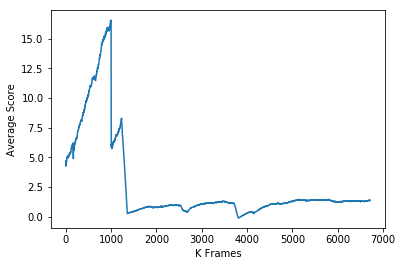

In [23]:
f = open(str(sign)+'/train_log.txt', 'r')

line = f.read().strip().split('\n')
values = []
for ln in line:
    segs = ln.split('/')
    values.append(float(segs[-1].split(' ')[-1]))
    
plt.figure()
plt.plot(np.arange(len(values)), values)
plt.xlabel('K Frames')
plt.ylabel('Average Score')
plt.show()

### 实时运行效果

In [29]:
use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
itype = torch.cuda.LongTensor if use_cuda else torch.LongTensor


player = Net(MEMORY, ACTION_N)
player.load_state_dict(torch.load('exp-20171215-153356/star-parms-6710000.pkl'))

if use_cuda:
    player.cuda()

## 对游戏状态的记忆
np_st = 0
## 游戏次数
np_life = 3
## 得分
np_score = 0
np_total_score = []

    
# action, stop = play(i, action, image, reward, game_over)
def net_player(i, action, image, reward, is_over):
    global player, np_st, np_life, np_score, np_total_score
    
    np_score += reward
    
    ## 统计命数和得分
    if is_over:
        np_life -=1
        np_total_score.append(np_score)
        np_score = 0        
    
    ## 游戏结束
    if np_life == 0:
        print('\n'.join('第{}轮得分：{:.2f}'.format(i+1, np_total_score[i]) for i in range(len(np_total_score))));
        print('总得分：{:.2f}'.format(np.sum(np_total_score)))
        return [], True
    
    
    ## 输入图像
    image = rgb2gray(image, IMAGE_WIDTH, IMAGE_HEIGHT)
    if i==0:
        np_st = np.stack((image,image,image,image), axis=0)
    else:
        image = image.reshape(1, image.shape[0], image.shape[1])
        np_st = np.append(image, np_st[:3, :, :], axis=0)
        
    input = Variable(torch.FloatTensor(np_st).type(dtype)).unsqueeze(0)
    q = player(input)
    maxv, maxi = q.data.max(1)
    action = class2action(maxi[0])
        
    return action, False

第1轮得分：0.27
第2轮得分：6.20
第3轮得分：-0.48
总得分：5.99


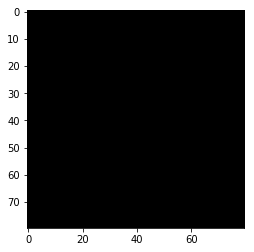

In [31]:
## 对游戏状态的记忆
np_st = 0
## 游戏次数
np_life = 3
## 得分
np_score = 0
np_total_score = []

# 运行游戏
show_play(net_player)